In [28]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 
from ctapipe.image.extractor import LocalPeakWindowSum
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr_all_camera import get_mean_time, get_corr_time, extract_pulse_time, ArrivalTimeCorr

plt.rcParams['font.size'] = 25

In [2]:
config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400}
})

hf = h5py.File('coeff.h5', 'r')
fan = hf.get('fan')
fan_array = np.array(fan)
fbn = hf.get('fbn')
fbn_array = np.array(fbn)
hf.close()

In [15]:
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
#input_file_2 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0001.fits.fz"
N_events = 3000
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
n_harm = 16
ArrTimeCorr = ArrivalTimeCorr(fan_array, fbn_array, n_harm)


for i, ev in enumerate(reader):
    if i%200 == 0:
        print(i)
    lst_r0.calibrate(ev)
    ArrTimeCorr.corr_arrivial_time(ev, N_module=265)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800


In [16]:
expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
arrival_time_list = ArrTimeCorr.get_arrivial_time_list()
arrival_time_corr_list = ArrTimeCorr.get_arrivial_time_corr_list()
std_before_corr = np.zeros(1855)
std_after_corr = np.zeros(1855)
for nr in range(0, 265):
    for pix in range(0, 7):
        pixel_id = expected_pixel_id[nr*7 + pix]
        std_arrival = np.nanstd(arrival_time_list[pixel_id])
        std_corr_arrival = np.nanstd(arrival_time_corr_list[pixel_id])
        std_before_corr[pixel_id] = (std_arrival)
        std_after_corr[pixel_id] = (std_corr_arrival)

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


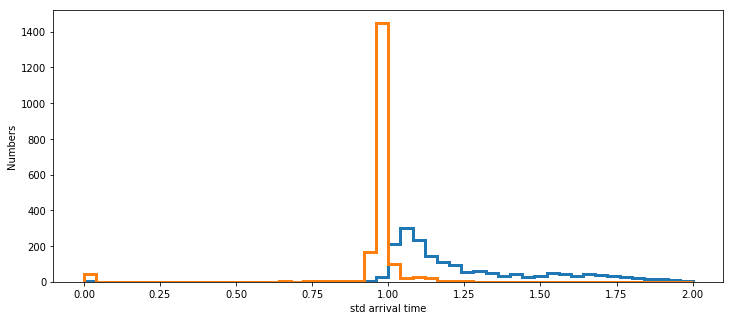

In [17]:
plt.figure(figsize=(12, 5))
plt.hist(std_before_corr, bins=50, range=(0., 2), histtype='step', lw=3)
plt.hist(np.nan_to_num(std_after_corr), bins=50, range=(0., 2), histtype='step', lw=3)
#plt.yscale('log')
plt.ylabel("Numbers")
plt.xlabel("std arrival time")
plt.show()

In [18]:
np.nanmean(std_after_corr)

0.9807617238456467

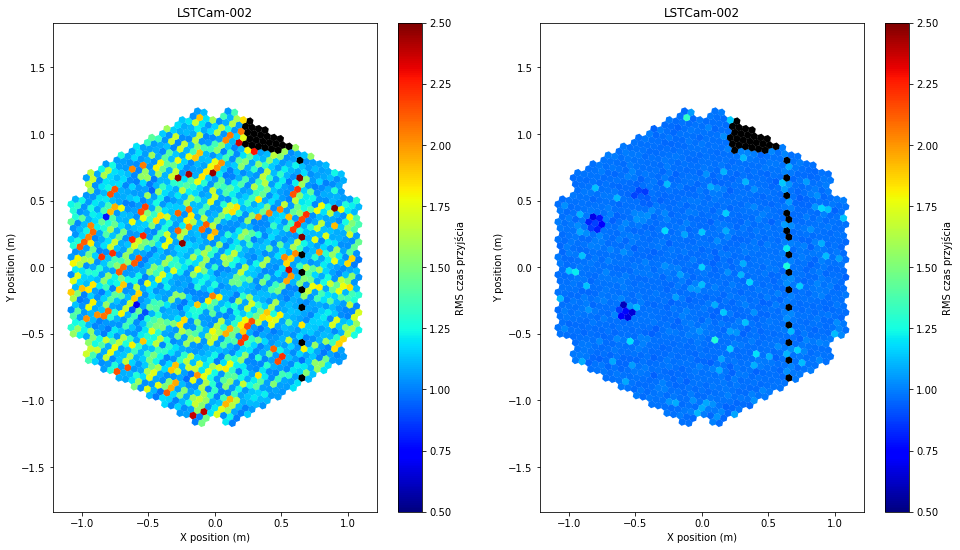

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[0])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(std_before_corr)
disp0.add_colorbar(ax=ax[0], label="RMS czas przyjścia")
disp0.set_limits_minmax(0.5, 2.5)    
disp0.cmap.set_under('black')        
        
disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[1])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(std_after_corr)
disp0.add_colorbar(ax=ax[1], label="RMS czas przyjścia")
disp0.set_limits_minmax(0.5, 2.5)
disp0.cmap.set_under('black')

In [26]:
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
n_harm = 16
N_events = 1000
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
extractor = LocalPeakWindowSum()

mean_time_list = []
dt_list = [[] for i in range(1855)]

for i, ev in enumerate(reader):
    print(i)
    lst_r0.calibrate(ev)
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
    try:
        charge, _ = extractor(baseline_subtracted)
        pulse_time =  extract_pulse_time(baseline_subtracted[0, :, :])
        mean_time = np.mean(pulse_time[np.where(charge[0, :] > 1500)])
        for nr in prange(0, 265):
            fc = get_first_capacitor(ev, nr)
            for pix in prange(0, 7):
                pixel = expected_pixel_id[nr*7 + pix]
            
                if charge[0, pixel] > 1500:
                    corr_pos = get_corr_time(fc[0, pix]%1024, fan_array[pixel], fbn_array[pixel],
                                                        fNumHarmonics=n_harm)
                    corr_time = pulse_time[pixel] - corr_pos + get_mean_time(fan_array[pixel])
                    dt = corr_time - mean_time
                    dt_list[pixel].append(dt)
        mean_time_list.append(mean_time)
    except Exception as err:
        pass

0
1
24.334263346598487
2
3
25.62137816817498
4
5
26.381556445689224
6
7
24.82455163675033
8
9
26.325152484299643


In [25]:
fan_array[10][0]/2

27.347086041858567

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


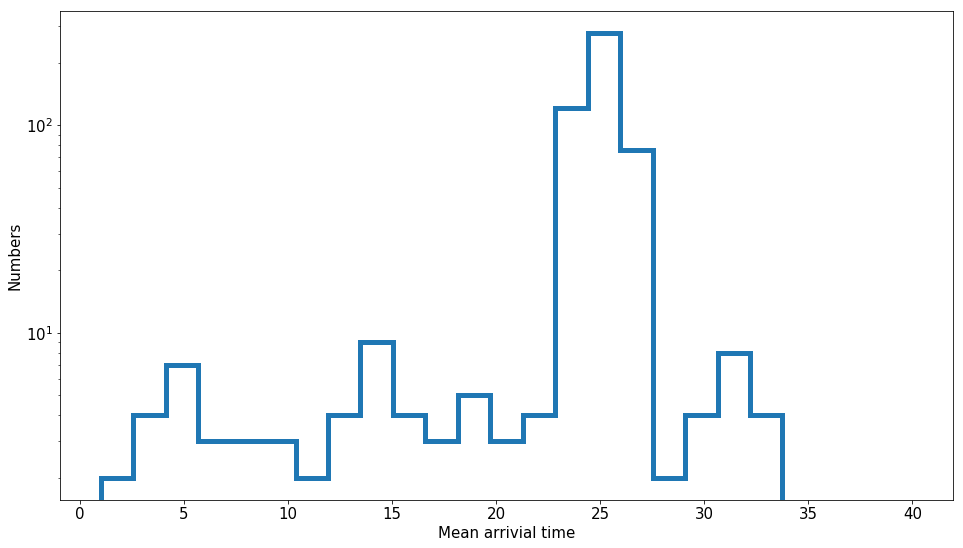

In [23]:
plt.figure(figsize=(16, 9))
plt.hist(mean_time_list, bins=25, range=(1, 40), histtype='step',lw=5)
plt.ylabel("Numbers")
plt.xlabel("Mean arrivial time")
plt.yscale('log')

In [19]:
mean_dt_arrival_time = []
for i in range(0 , 1855):
    mean_dt_arrival_time.append(np.nanmean(dt_list[i]))

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


(array([  0.,   0.,  42.,   0.,   5.,   1.,   0.,   0.,   6.,  22., 179.,
        388., 638., 414., 117.,  15.,   3.,   4.,   0.,   4.,   5.,   5.,
          7.,   0.,   0.]),
 array([-10. ,  -9.2,  -8.4,  -7.6,  -6.8,  -6. ,  -5.2,  -4.4,  -3.6,
         -2.8,  -2. ,  -1.2,  -0.4,   0.4,   1.2,   2. ,   2.8,   3.6,
          4.4,   5.2,   6. ,   6.8,   7.6,   8.4,   9.2,  10. ]),
 <a list of 1 Patch objects>)

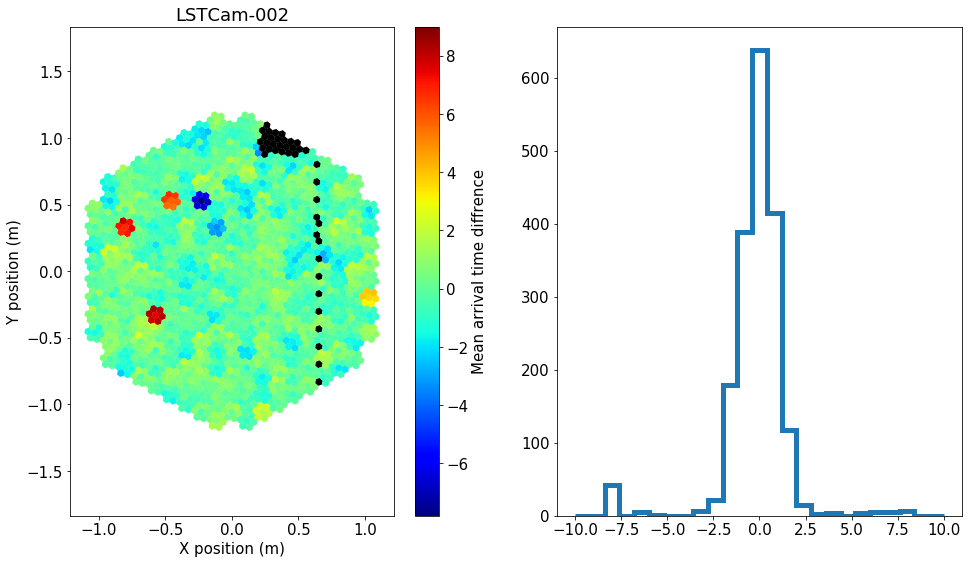

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[0])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(mean_dt_arrival_time)
disp0.add_colorbar(ax=ax[0], label="Mean arrival time diffrence")
disp0.set_limits_minmax(9, -7.8)  
disp0.cmap.set_under('black')

ax[1].hist(np.nan_to_num(mean_dt_arrival_time), bins=25, range=(-10, 10), 
                         histtype='step',lw=5)

In [ ]:
np.sort(mean_dt_arrival_time)[:50] 

In [ ]:
np.sum(np.isnan(mean_dt_arrival_time))

In [ ]:
np.array(mean_dt_arrival_time)[np.where(np.isnan(mean_dt_arrival_time))] = 100

In [ ]:
fan_array[620]

In [ ]:
mean_dt_arrival_time[1522]

In [ ]:
np.nan_to_num(mean_dt_arrival_time[1522])

In [21]:
for i in np.where(np.isnan(mean_dt_arrival_time))[0]:
    mean_dt_arrival_time[i] = -8

In [ ]:
np.where(np.array(mean_dt_arrival_time) > 5)

In [49]:
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
n_harm = 16
N_events = 1000
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
extractor = LocalPeakWindowSum()

mean_time_list = []
#dt_list = [[] for i in range(1855)]

for i, ev in enumerate(reader):
    print(i)
    lst_r0.calibrate(ev)
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
    try:
        charge, _ = extractor(baseline_subtracted)
        pulse_time =  extract_pulse_time(baseline_subtracted[0, :, :])
        corr_time_list = []
        for nr in prange(0, 265):
            fc = get_first_capacitor(ev, nr)
            for pix in prange(0, 7):
                pixel = expected_pixel_id[nr*7 + pix]
            
                if charge[0, pixel] > 1500:
                    corr_pos = get_corr_time(fc[0, pix]%1024, fan_array[pixel], fbn_array[pixel],
                                                        fNumHarmonics=n_harm)
                    corr_time = pulse_time[pixel] - corr_pos 
                    corr_time_list.append(corr_time)
        if len(corr_time_list) > 1500:    
            mean_time_list.append(np.nanmean(corr_time_list))
            print(len(corr_time_list))
    except Exception as err:
        pass

0
1
1809
2
3
1805
4
5
1808
6
7
1811
8
9
1805
10
11
12
1804
13
14
1809
15
16
1809
17
18
1808
19
20
1807
21
22
1804
23
24
1808
25
26
27
1804
28
29
30
1806
31
32
1808
33
34
1806
35
36
1806
37
38
1807
39
40
1810
41
42
43
44
45
1808
46
47
1809
48
49
1807
50
51
1806
52
53
1807
54
55
1808
56
57
1806
58
59
1809
60
61
1807
62
63
1809
64
65
1808
66
67
1807
68
69
70
71
1806
72
73
1806
74
75
1807
76
77
1808
78
79
1805
80
81
1807
82
83
1806
84
85
1807
86
87
1806
88
89
1807
90
91
1811
92
93
1808
94
95
1807
96
97
1805
98
99
1808
100
101
1807
102
103
1805
104
105
1806
106
107
1808
108
109
1808
110
111
1806
112
113
1808
114
115
1805
116
117
1807
118
119
1809
120
121
1805
122
123
1807
124
125
1808
126
127
1804
128
129
1808
130
131
1806
132
133
1808
134
135
1812
136
137
1806
138
139
1808
140
141
1808
142
143
1807
144
145
1807
146
147
1808
148
149
1808
150
151
1806
152
153
154
1809
155
156
1809
157
158
1807
159
160
1808
161
162
1805
163
164
1809
165
166
1808
167
168
1810
169
170
1808
171
172
1807
173
174


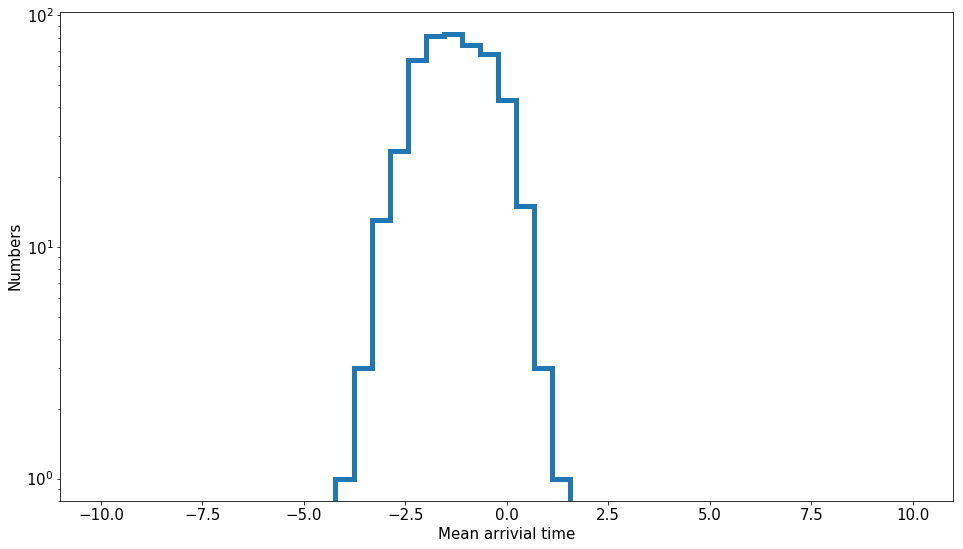

In [50]:
plt.figure(figsize=(16, 9))
plt.hist(mean_time_list, bins=45, range=(-10, 10), histtype='step',lw=5)
plt.ylabel("Numbers")
plt.xlabel("Mean arrivial time")
plt.yscale('log')

In [51]:
np.std(mean_time_list)

0.8910590765993313

In [13]:
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
n_harm = 16
N_events = 500
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
extractor = LocalPeakWindowSum()

mean_time_list = []
dt_list = [[] for i in range(1855)]

for i, ev in enumerate(reader):
    print(i)
    lst_r0.calibrate(ev)
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
    try:
        charge, _ = extractor(baseline_subtracted)
        pulse_time =  extract_pulse_time(baseline_subtracted[0, :, :])
        corr_time_list = []
        for nr in prange(0, 265):
            fc = get_first_capacitor(ev, nr)
            for pix in prange(0, 7):
                pixel = expected_pixel_id[nr*7 + pix]
            
                if charge[0, pixel] > 1500:
                    corr_pos = get_corr_time(fc[0, pix]%1024, fan_array[pixel], fbn_array[pixel],
                                                        fNumHarmonics=n_harm)
                    corr_time = pulse_time[pixel] - corr_pos 
                    corr_time_list.append(corr_time)
        if len(corr_time_list) > 1500:  
            mean_time = np.nanmean(corr_time_list)
            mean_time_list.append(mean_time)
            print(len(corr_time_list))
            
            for nr in prange(0, 265):
                fc = get_first_capacitor(ev, nr)
                for pix in prange(0, 7):
                    pixel = expected_pixel_id[nr*7 + pix]
            
                    if charge[0, pixel] > 1500:
                        corr_pos = get_corr_time(fc[0, pix]%1024, fan_array[pixel], fbn_array[pixel],
                                                        fNumHarmonics=n_harm)
                        corr_time = pulse_time[pixel] - corr_pos 
                        dt = corr_time - mean_time
                        dt_list[pixel].append(dt)
                                  
    except Exception as err:
        print(err)

0
1
1809
2
Weights sum to zero, can't be normalized
3
1805
4
Weights sum to zero, can't be normalized
5
1808
6
Weights sum to zero, can't be normalized
7
1811
8
Weights sum to zero, can't be normalized
9
1805
10
Weights sum to zero, can't be normalized
11
Weights sum to zero, can't be normalized
12
1804
13
14
1809
15
Weights sum to zero, can't be normalized
16
1809
17
Weights sum to zero, can't be normalized
18
1808
19
20
1807
21
Weights sum to zero, can't be normalized
22
1804
23
24
1808
25
Weights sum to zero, can't be normalized
26
Weights sum to zero, can't be normalized
27
1804
28
29
Weights sum to zero, can't be normalized
30
1806
31
Weights sum to zero, can't be normalized
32
1808
33
Weights sum to zero, can't be normalized
34
1806
35
36
1806
37
38
1807
39
Weights sum to zero, can't be normalized
40
1810
41
Weights sum to zero, can't be normalized
42
Weights sum to zero, can't be normalized
43
Weights sum to zero, can't be normalized
44
Weights sum to zero, can't be normalized
4

1810
496
497
1812
498
Weights sum to zero, can't be normalized
499
1807


0.8937378431249609


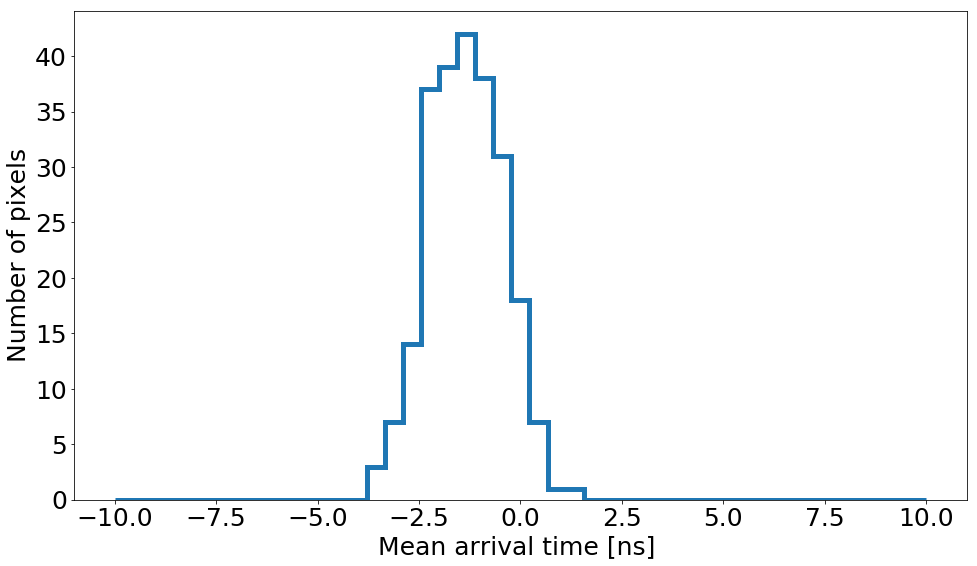

In [43]:
plt.figure(figsize=(16, 9))
plt.hist(mean_time_list, bins=45, range=(-10, 10), histtype='step',lw=5)

#plt.yscale('log')
plt.ylabel("Number of pixels")
plt.xlabel("Mean arrival time [ns] ")
print(np.std(mean_time_list))
plt.savefig("hist_arrival_time.png")

In [20]:
np.nanmean(dt_list[1800])

-0.042706411058597904

In [23]:
mean_dt_arrival_time = []
for i in range(0 , 1855):
    mean_dt_arrival_time.append(np.nanstd(dt_list[i]))

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.707e+03,
        9.500e+01, 8.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 <a list of 1 Patch objects>)

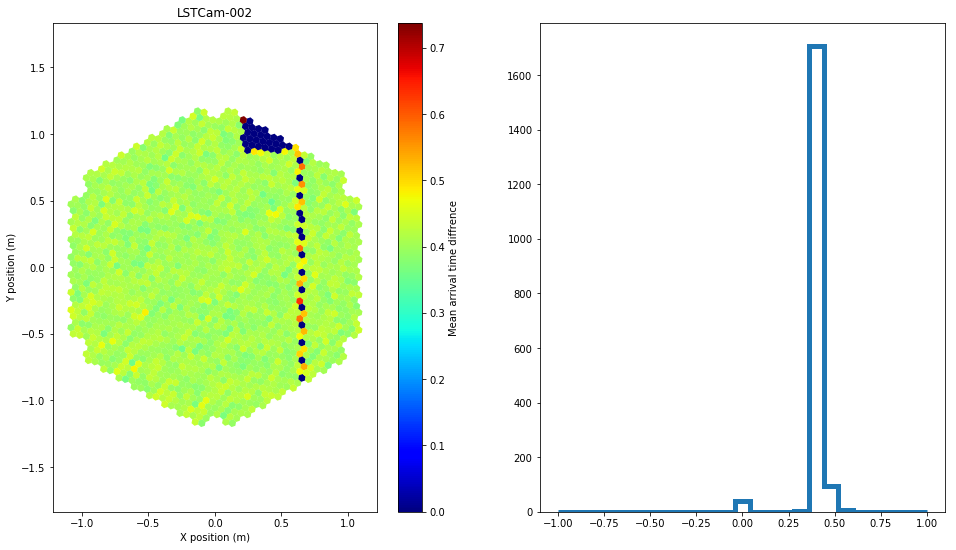

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[0])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(mean_dt_arrival_time)
disp0.add_colorbar(ax=ax[0], label="Mean arrival time diffrence")
#disp0.set_limits_minmax(9, -7.8)  
#disp0.cmap.set_under('black')

ax[1].hist(np.nan_to_num(mean_dt_arrival_time), bins=25, range=(-1, 1), 
                         histtype='step',lw=5)

In [25]:
np.nanmean(mean_dt_arrival_time)

0.40946656487908617

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


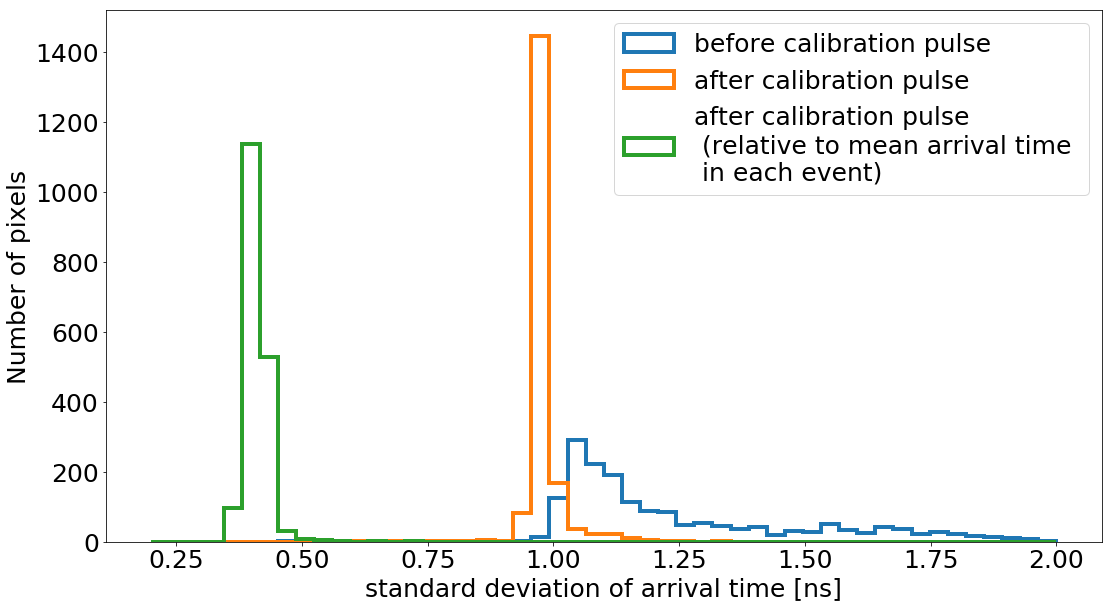

In [47]:
plt.figure(figsize=(16, 9))
plt.hist(std_before_corr, bins=50, range=(0.2, 2), histtype='step', lw=4, 
         label="before calibration pulse")
plt.hist(np.nan_to_num(std_after_corr), bins=50, range=(0.2, 2), histtype='step', lw=4, 
         label="after calibration pulse")
plt.hist(np.nan_to_num(mean_dt_arrival_time), bins=50, range=(0.2, 2), 
                         histtype='step',lw=4, label="after calibration pulse \n (relative to mean arrival time \n in each event)")
#plt.yscale('log')
plt.ylabel("Number of pixels")
plt.xlabel("standard deviation of arrival time [ns]")
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig("hist_std_arrival_time.png")

plt.show()
